# Imports

In [34]:
import pandas as pd
import numpy as np
import sys
import os
import joblib
# model interpretation
import shap
# modelisation 
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, log_loss, roc_auc_score, brier_score_loss, accuracy_score, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import sklearn
from xgboost import XGBClassifier
# preprocessing
import optbinning
# reweighting
import cinnamon
from cinnamon.drift import ModelDriftExplainer, AdversarialDriftExplainer
# graphviz
import matplotlib.pyplot as plt
import seaborn as sns
# Dimension reduction
import umap
# R libraries partykit
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import Formula
from rpy2.rinterface_lib.embedded import RRuntimeError


grdevices = importr('grDevices')
partykit = importr('partykit')

# Display all columns in the notebook
pd.set_option('display.max_columns', None)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [2]:
SAVE_BEST_PIPELINES = False

# 1. Opening dataset Customer data lead generator

In [3]:
!ls ../data/

CustomerData_LeadGenerator.csv
cv_metrics_df.csv
mean_metrics_df.csv
sample_temperature_data_for_coding_challenge.csv
scorecard.csv


In [4]:
df1 = pd.read_csv('../data/CustomerData_LeadGenerator.csv')

## 1.1. Exploration

In [5]:
df1.head()

,fakeID,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_OpeningDays,q_OpeningHours,q_2017 Average Household Size,q_2017 Total Households,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
0,1069_7334,0,0,0,0,0,0,0,0,0,1,4,36,2.1,1045481,195228,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1,1
1,328_2350,0,0,0,1,1,1,0,0,0,0,4,20,2.1,935739,168291,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1,1
2,865_6285,0,0,0,1,0,1,0,0,0,1,0,0,2.1,1026235,189787,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1,1
3,47_307,0,1,1,0,0,0,0,0,0,0,4,20,2.1,1027701,189634,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,1,0
4,342_2513,0,0,0,0,0,1,0,0,0,1,5,33,2.1,1093324,207590,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1,1


In [6]:
df1.b_in_kontakt_gewesen.value_counts()

0    3678
1      95
Name: b_in_kontakt_gewesen, dtype: int64

In [7]:
df1.b_gekauft_gesamt.value_counts()

0    3716
1      57
Name: b_gekauft_gesamt, dtype: int64

In [8]:
df1.describe()

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_OpeningDays,q_2017 Average Household Size,q_2017 Total Households,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
count,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3.773000e+03,3773.000000,3773.000000,3773.000000,3.773000e+03,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000
mean,0.218129,0.224225,0.254704,0.111582,0.285449,0.005566,0.002650,0.020408,0.138616,0.254174,3.230586,2.242221,3.873879e+05,73575.237477,0.197419,23170.651983,8.257315e+05,111252.936920,0.101737,574.247339,326.438110,234.848630,0.025179,0.015107
std,0.413030,0.417126,0.435753,0.314894,0.451688,0.074407,0.051421,0.141411,0.345592,0.435454,2.070304,0.153143,4.116316e+05,75533.849191,0.024973,1147.978703,8.565966e+05,131837.721022,0.039749,22.966321,11.135183,11.018168,0.156689,0.121996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.718000e+03,316.000000,0.100814,19171.140000,3.807000e+03,172.000000,0.027974,490.390000,270.110000,196.450000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.100000,7.571800e+04,15441.000000,0.184566,22662.050000,1.780610e+05,11431.000000,0.063095,560.130000,322.380000,231.310000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.200000,1.537120e+05,34165.000000,0.195882,23627.240000,3.417850e+05,39282.000000,0.101592,584.000000,325.860000,235.290000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,2.400000,9.651600e+05,174038.000000,0.213667,23839.540000,2.023342e+06,298968.000000,0.145630,592.520000,331.930000,238.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,2.900000,1.113261e+06,212126.000000,0.269397,26008.530000,2.350279e+06,337338.000000,0.170786,610.140000,363.230000,274.140000,1.000000,1.000000


# 2. Baseline model : Modelling with labeled data only

In [9]:
df1.groupby(['b_in_kontakt_gewesen', 'b_gekauft_gesamt']).size().reset_index(name='counts')

,b_in_kontakt_gewesen,b_gekauft_gesamt,counts
0,0,0,3678
1,1,0,38
2,1,1,57


### Conclusion:
If there are no contacts whatsoever, then there are zero clients buying. On the other hand, being in contact does not always lead to final purchase from the client. 

## 2.1 We select df_training for records where team has been in contact with client

In [10]:
df_training = df1[lambda x: x["b_in_kontakt_gewesen"]==1].copy()
# Perform stratified sampling to get 50% of the data
X = df_training.drop(columns=['b_gekauft_gesamt', 'fakeID'])  # Features
y = df_training['b_gekauft_gesamt']  # Target variable

# Split the data into training and testing sets, stratifying by y
X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Concatenate X_sampled and y_sampled to get the sampled DataFrame
df_sampled = pd.concat([X_sampled, y_sampled], axis=1)

In [11]:
# Split the data into training and testing sets, stratifying by y
X_train_cv, X_val, y_train_cv, y_val =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
print("Shape of X_train_cv:", X_train_cv.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train_cv:", y_train_cv.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train_cv: (76, 24)
Shape of X_val: (19, 24)
Shape of y_train_cv: (76,)
Shape of y_val: (19,)


In [13]:
print(np.round(y_val.sum()/X_val.shape[0],2))
print(np.round(y_train_cv.sum()/X_train_cv.shape[0],2))

0.58
0.61


## 2.2. Cross-validation on X_train_cv dataset - a validation dataset is kept for final evaluation

In [15]:
def pipeline_creation(X_train, y_train, model, param_grid):
    # Define pipeline with preprocessor and model
    pipeline = Pipeline([
            (
                "encoder",
                optbinning.BinningProcess(
                    variable_names=X_train.columns.tolist(),
                    # categorical_variables=v3_cat_features,
                   max_pvalue=0.05,
                ),
            ),
            (
                "model",
                model,
            ),
    ])

    
    # Define the evaluation metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'brier': 'neg_brier_score',
        'roc_auc': 'roc_auc'
    }

    grid_search = GridSearchCV(
                                pipeline,
                                param_grid=param_grid,
                                cv=KFold(n_splits=3, shuffle=True, random_state=0),
                                scoring=scoring,
                                refit='roc_auc',
                                return_train_score=True,
                                n_jobs=-1  # Run in parallel
                            )
    grid_search.fit(X_train, y_train)

    # Retrieve the best pipeline
    best_pipeline = grid_search.best_estimator_
    
    # Retrieve the fitted BinningProcess
    binning_process = best_pipeline.named_steps['encoder']
    
    # Print the summary of the BinningProcess
    summary = binning_process.summary()
    
    # Retrieve cross-validation results
    cv_results = grid_search.cv_results_
    # Compute relevant metrics
    metrics_df = pd.DataFrame({
        'Accuracy': cv_results['mean_test_accuracy'],
        'Accuracy Std': cv_results['std_test_accuracy'],
        'Precision': cv_results['mean_test_precision'],
        'Precision Std': cv_results['std_test_precision'],
        'Recall': cv_results['mean_test_recall'],
        'Recall Std': cv_results['std_test_recall'],
        'F1': cv_results['mean_test_f1'],
        'F1 Std': cv_results['std_test_f1'],
        'AUC': cv_results['mean_test_roc_auc'],
        'AUC Std': cv_results['std_test_roc_auc'],
        'Brier': -cv_results['mean_test_brier'],  # negate back
        'Brier Std': cv_results['std_test_brier'],
        'AUC Train': cv_results['mean_train_roc_auc'],
        'AUC Train Std': cv_results['std_train_roc_auc']
    })
    return best_pipeline, cv_results, metrics_df, summary, binning_process


### Testing three models with a gridsearch of hyperparameters which aim at avoiding overfitting as much as possible. 

In [16]:
# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [1, 2, 5],#, None],
    'model__min_samples_split': [2, 5],#, 10],
    'model__min_samples_leaf': [1, 2],#, 4],
    'model__bootstrap': [True],
}

# Define the hyperparameter grid for Logistic Regression
lr_param_grid = {
    'model__C': np.logspace(-3, 1, 10),
    'model__solver': ["saga"],
    'model__penalty': ["l1", "l2"], # ridge and lasso 
    'model__max_iter': [5000]
}

xgb_param_grid = {
    'model__learning_rate': [0.1, 0.01],       
    'model__n_estimators': [100, 200],    # Fewer values to limit overfitting
    'model__max_depth': [1, 2, 5],           # Limit the maximum depth
    'model__subsample': [0.8, 1.0]        # Consider two values for subsampling
}


# Initialize an empty DataFrame to store results
final_metrics_df = pd.DataFrame()

# Define your models
models = {
    'Random Forest': (RandomForestClassifier(random_state=0), rf_param_grid),
    'Logistic Regression': (LogisticRegression(random_state=0), lr_param_grid),
    'XGBoost': (XGBClassifier(random_state=0), xgb_param_grid)
}

# Initialize an empty DataFrame to store results
final_metrics_df = pd.DataFrame()

best_pipelines = {}
for model_name, (model, param_grid) in models.items():
    print(f'CROSS-VALIDATION STARTED for {model_name}')
    best_pipeline, cv_results, cv_metrics_df, summary, binning_process = pipeline_creation(X_train_cv, y_train_cv, model, param_grid)
    # Store the best pipeline in the dictionary
    best_pipelines[model_name] = best_pipeline
    # Add model name to the metrics dataframe
    cv_metrics_df['Model'] = model_name
    # Append the results to the final dataframe
    final_metrics_df = pd.concat([final_metrics_df, cv_metrics_df], ignore_index=True)

CROSS-VALIDATION STARTED for Random Forest
(CVXPY) Jun 24 07:45:01 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 24 07:45:01 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 24 07:45:01 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 24 07:45:01 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for t

/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is d

[20:05:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [17]:
# Save the final metrics dataframe to a CSV file
final_metrics_df.to_csv("../data/cv_metrics_df.csv", index=False)

# Compute the mean and standard deviation of the metrics for each model
mean_metrics_df = final_metrics_df.groupby('Model').agg(['mean', 'std']).reset_index()

# Flatten the multi-level columns
mean_metrics_df.columns = [' '.join(col).strip() for col in mean_metrics_df.columns.values]

# Save the mean metrics dataframe to a CSV file
mean_metrics_df.sort_values(['AUC mean'], ascending=False).to_csv("../data/mean_metrics_df.csv", index=False)

In [18]:
mean_metrics_df.sort_values(['AUC mean'], ascending=False)

,Model,Accuracy mean,Accuracy std,Accuracy Std mean,Accuracy Std std,Precision mean,Precision std,Precision Std mean,Precision Std std,Recall mean,Recall std,Recall Std mean,Recall Std std,F1 mean,F1 std,F1 Std mean,F1 Std std,AUC mean,AUC std,AUC Std mean,AUC Std std,Brier mean,Brier std,Brier Std mean,Brier Std std,AUC Train mean,AUC Train std,AUC Train Std mean,AUC Train Std std
1,Random Forest,0.583547,0.016767,0.050784,0.014017,0.622853,0.011906,0.076332,0.012592,0.820670,0.057128,0.060301,0.021225,0.701805,0.021041,0.042296,0.013122,0.471222,0.012804,0.115586,0.019068,0.282682,0.023710,0.021397,0.002824,0.907725,0.017981,0.038885,0.004481
2,XGBoost,0.565962,0.030798,0.092324,0.024797,0.624130,0.028024,0.081126,0.018778,0.680214,0.041924,0.106127,0.054961,0.648874,0.034104,0.092378,0.033263,0.452998,0.017824,0.163665,0.010606,0.306287,0.030746,0.041194,0.016883,0.913204,0.014603,0.037761,0.006314
0,Logistic Regression,0.559615,0.035828,0.076000,0.008486,0.601487,0.007687,0.090812,0.011251,0.834036,0.124872,0.046141,0.043388,0.690163,0.047818,0.062996,0.010777,0.450991,0.035342,0.098040,0.054137,0.297710,0.044659,0.033883,0.019331,0.818742,0.164286,0.029206,0.015345


In [51]:
91-47

44

In [52]:
82-45

37

### Best model hyperparameters

In [14]:
if SAVE_BEST_PIPELINES:
    joblib_file = "models/best_pipelines.joblib"
    
    # Save the model
    joblib.dump(best_pipelines, joblib_file)
    
    print(f"Model saved as {joblib_file}")
else:
    print("best_pipelines was already generated")
    # Load the model
    best_pipelines = joblib.load("models/best_pipelines.joblib")

best_pipelines was already generated


In [15]:
best_params = best_pipelines["Random Forest"].named_steps['model'].get_params()
# Now best_params contains the best parameters of the model
print("Best parameters of the model:")
best_params

Best parameters of the model:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### Performance on validation dataset

In [16]:
# X_val and y_val are your validation set
y_val_pred_proba = best_pipelines["Random Forest"].predict_proba(X_val)[:, 1]

# Compute AUC on validation set
auc_val = np.round(roc_auc_score(y_val, y_val_pred_proba),2)

print(f'AUC on Validation Set: {auc_val}')

AUC on Validation Set: 0.58


## 2.3 Optimal binning insights

In [24]:
summary

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,b_specialisation_i,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
1,b_specialisation_h,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
2,b_specialisation_g,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
3,b_specialisation_f,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
4,b_specialisation_e,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
5,b_specialisation_d,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
6,b_specialisation_c,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
7,b_specialisation_b,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
8,b_specialisation_a,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
9,b_specialisation_j,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0


In [25]:
binning_process.information()

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                     76
    Number of variables                   24
    Target type                       binary

    Number of numerical                   23
    Number of categorical                  1
    Number of selected                    24

  Time                                0.4047 sec



In [26]:
optb = binning_process.get_binned_variable("q_OpeningHours")

In [27]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[10, 21, 21.5, 5, 39, 7, 53, 36.5, 25]",12,0.157895,11,1,0.083333,2.825339,0.974537,0.092715
1,"[20, 9, 28, 17, 12, 36, 0]",41,0.539474,17,24,0.585366,0.082604,0.003711,0.000464
2,"[27, 29, 23, 20.5, 15, 22, 24, 30, 34, 35, 32,...",23,0.302632,2,21,0.913043,-1.923931,0.750054,0.081536
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,76,1.000000,30,46,0.605263,,1.728303,0.174715


In [28]:
optb.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.56884058
    IV (Jeffrey)             1.72830285
    JS (Jensen-Shannon)      0.17471471
    Hellinger                0.19252472
    Triangular               0.59867220
    KS                       0.38985507
    HHI                      0.40754848
    HHI (normalized)         0.25943560
    Cramer's V               0.54855412
    Quality score            0.00038170

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     9.388725 0.002183  0.000263  0.999737
        1      2     7.579126 0.005905  0.000720  0.999280



### 2.3.1 Optimal binning Scorecard

In [29]:
binning_tables = []
# Access and build binning tables for each variable
for variable in X.columns:
    optb = binning_process.get_binned_variable(variable)
    binning_table = optb.binning_table.build()
    binning_table['variable'] = variable  # Add a column to identify the variable
    binning_tables.append(binning_table)

# Concatenate all binning tables into a single DataFrame
all_binning_tables = pd.concat(binning_tables, ignore_index=True)

In [30]:
all_binning_tables.to_csv("../data/scorecard.csv")

In [31]:
all_binning_tables

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,variable
0,"(-inf, inf)",76,1.0,30,46,0.605263,0.0,0.0,0.0,b_specialisation_i
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0,b_specialisation_i
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0,b_specialisation_i
3,,76,1.0,30,46,0.605263,,0.0,0.0,b_specialisation_i
4,"(-inf, inf)",76,1.0,30,46,0.605263,0.0,0.0,0.0,b_specialisation_h
...,...,...,...,...,...,...,...,...,...,...
104,,76,1.0,30,46,0.605263,,0.0,0.0,q_2017 Personal Effects: Per Capita
105,"(-inf, inf)",76,1.0,30,46,0.605263,0.0,0.0,0.0,b_in_kontakt_gewesen
106,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0,b_in_kontakt_gewesen
107,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0,b_in_kontakt_gewesen


### Univariate plots from Optimal Binning scorecard to see the relationship between target and the bins created

Could not process variable q_OpeningHours
Plots saved in ./figures/univariate/


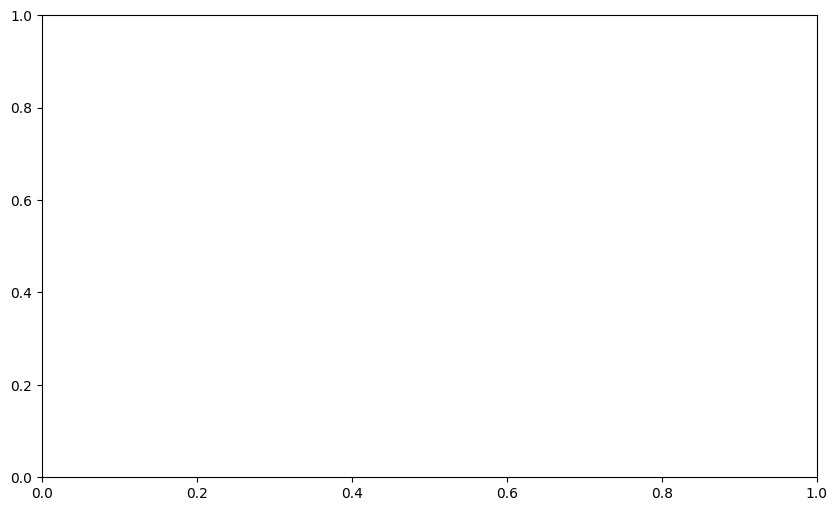

[19:45:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:46:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:48:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [32]:
# Ensure the directory exists or create it if it doesn't
figure_dir = './figures/univariate/'
os.makedirs(figure_dir, exist_ok=True)
# Filter the binning tables based on conditions
filtered_binning_tables = all_binning_tables#[
#     (all_binning_tables['Event rate'] > 0) & 
#     (~all_binning_tables['Bin'].isin([' 	(-inf, inf) 	']))
# ]

# Plotting each variable separately
for variable, data in filtered_binning_tables.groupby('variable'):
    try:
        plt.figure(figsize=(10, 6))
        plt.plot(data['Bin'], data['Event rate'], marker='o', linestyle='-')
        plt.xlabel('Bin')
        plt.ylabel('Event Rate')
        plt.title(f'Event Rate vs Bins for {variable}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        
        # Save the figure
        filename = f"{variable.replace('/', '-')}_dependence_plot.png"
        filepath = os.path.join(figure_dir, filename)
        plt.savefig(filepath)
        
        plt.close()  # Close the current plot to free memory
    except ValueError:
        print(f"Could not process variable {variable}")

print("Plots saved in ./figures/univariate/")

#### Conclusion:
We notice that Optimal binning identified some interesting pockets of population which more or less prone to purchase the final products in the following variables:
* q_2017 Personal Care: Per Capita_dependence_plot
* q_2017 Pop 15+-Edu: University, Fachhochschule_dependence_plot
* q_2017 Purchasing Power: Per Capita_dependence_plot (clear anti-linear relationship)
* q_2017 Total Households_dependence_plot
* q_2017 Total Population_dependence_plot
* q_5th Quint by Total HH_dependence_plot
* q_OpeningDays_dependence_plot
* q_Uni by Total Pop_dependence_plot

## 2.4. Shapley values and Feature importance analysis

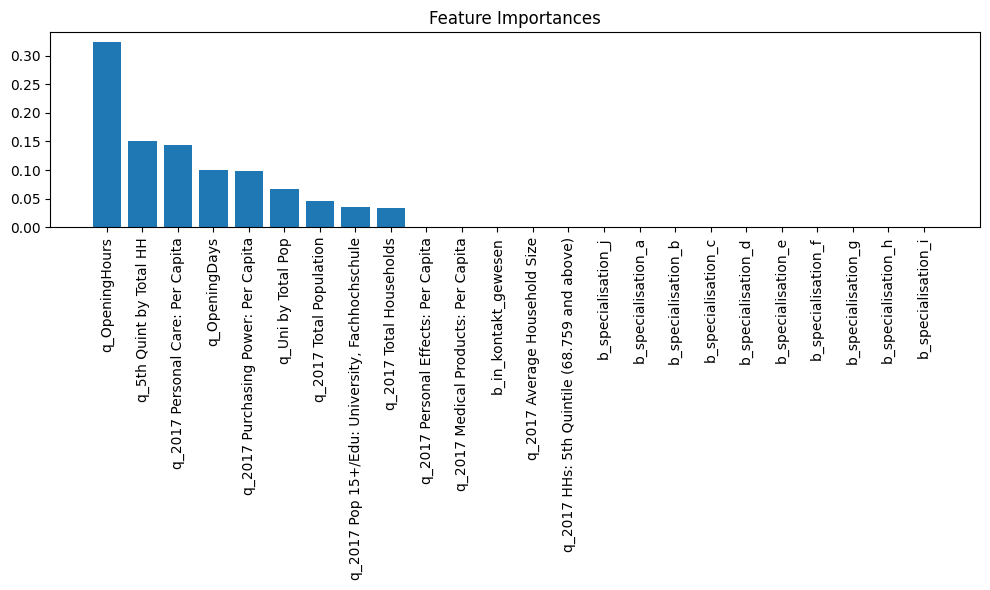

In [30]:
# Get feature importances from the model
importances = best_pipelines["Random Forest"].named_steps['model'].feature_importances_

# Get feature names from your dataset or wherever they are stored
feature_names = X_train_cv.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_feature_names = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
plt.tight_layout()
plt.show()

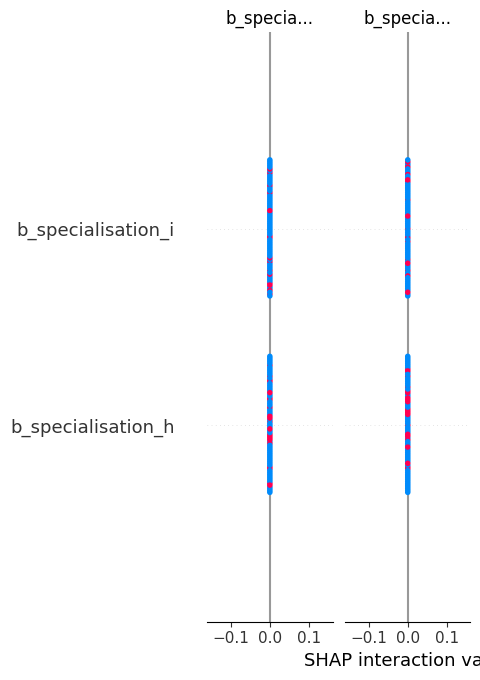

In [28]:
X_train_cv_ = X_train_cv.assign(
                                q_OpeningHours=lambda x: x.q_OpeningHours.astype('float'),
                                q_OpeningDays=lambda x: x.q_OpeningDays.astype('float')
)
explainer = shap.TreeExplainer(best_pipelines["Random Forest"].named_steps['model'])
# shap.initjs()
shap_values = explainer.shap_values(X_train_cv_, approximate=True)
# SHAP summary plot
shap.summary_plot(shap_values, X_train_cv_)

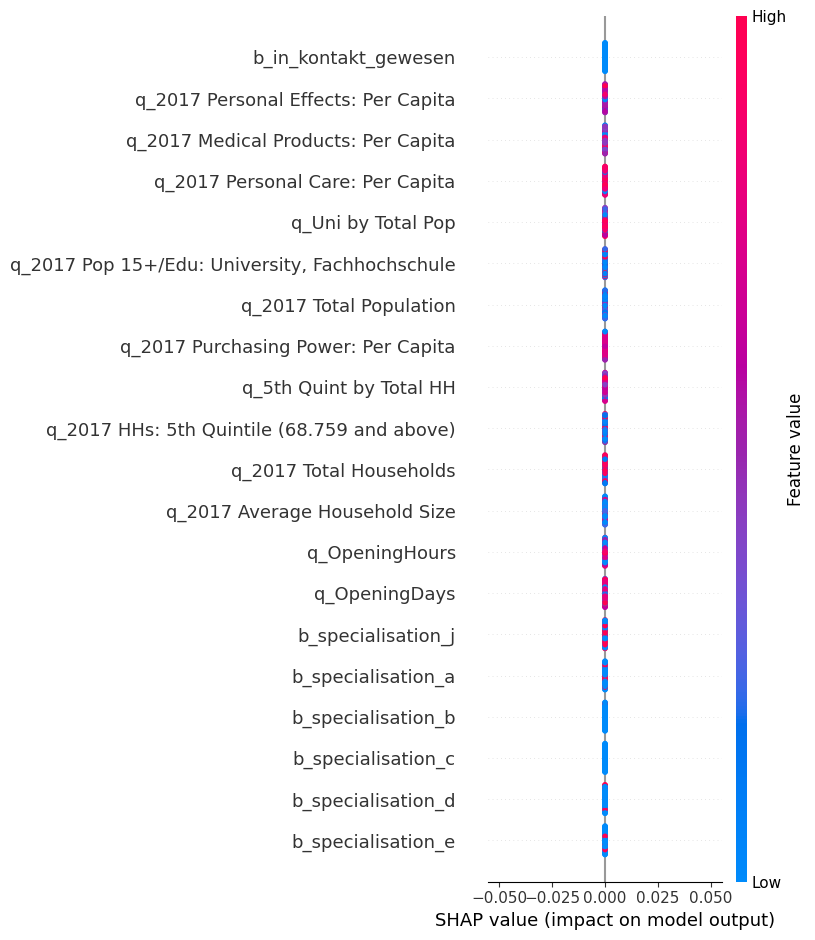

In [25]:
X_train_cv_ = X_train_cv.assign(
                                q_OpeningHours=lambda x: x.q_OpeningHours.astype('float'),
                                q_OpeningDays=lambda x: x.q_OpeningDays.astype('float')
)
# Compute SHAP values
explainer = shap.Explainer(best_pipelines["Logistic Regression"].named_steps['model'], X_train_cv_)
shap_values = explainer(X_train_cv_)

# SHAP summary plot
shap.summary_plot(shap_values, X_train_cv_)

## 2.5. Shapley Dependence plot

In [26]:
# Directory to save SHAP dependence plots
output_dir = './figures/shap/'
os.makedirs(output_dir, exist_ok=True)

# Function to sanitize file names
def sanitize_filename(filename):
    return filename.replace("/", "_").replace("\\", "_").replace(":", "_")

# Generate and save SHAP dependence plots for all features
for i, feature_name in enumerate(X_train_cv_.columns):
    plt.figure()
    shap.dependence_plot(i, shap_values.values, X_train_cv_, feature_names=X_train_cv_.columns, show=False)
    plt.title(f"SHAP Dependence Plot for {feature_name}")
    sanitized_feature_name = sanitize_filename(feature_name)
    plt.savefig(f"{output_dir}{sanitized_feature_name}_dependence_plot.png")
    plt.close()

print(f"SHAP dependence plots saved in {output_dir}")

/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/shap/plots/_scatter.py:579: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=figsize)
/tmp/ipykernel_128719/3840865620.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


SHAP dependence plots saved in ./figures/shap/


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## 2.6. Correlation matrix 

In [31]:
def pearson_correlation(X):
    data = X
    corr_pearson = data.corr(method='pearson')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_pearson)
    # drop correlated feature
    # Return a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_pearson.shape[0],), True, dtype=bool) 
    for i in range(corr_pearson.shape[0]):
        for j in range(i+1, corr_pearson.shape[0]):
            if corr_pearson.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_pearson = data.columns[columns]
    return selected_columns_pearson, corr_pearson

def spearman_correlation(X):
    data = X
    corr_spearman = data.corr(method='spearman')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    # Returns a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_spearman.shape[0],), True, dtype=bool) 
    for i in range(corr_spearman.shape[0]):
        for j in range(i+1, corr_spearman.shape[0]):
            if corr_spearman.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_spearman = data.columns[columns]
    return selected_columns_spearman, corr_spearman

(Index(['b_specialisation_i', 'b_specialisation_h', 'b_specialisation_g',
        'b_specialisation_f', 'b_specialisation_e', 'b_specialisation_d',
        'b_specialisation_c', 'b_specialisation_b', 'b_specialisation_a',
        'b_specialisation_j', 'q_OpeningDays', 'q_2017 Average Household Size',
        'q_2017 Total Households', 'q_5th Quint by Total HH',
        'q_2017 Purchasing Power: Per Capita',
        'q_2017 Medical Products: Per Capita', 'b_in_kontakt_gewesen'],
       dtype='object'),
                                                 b_specialisation_i  \
 b_specialisation_i                                        1.000000   
 b_specialisation_h                                        0.137157   
 b_specialisation_g                                        0.351683   
 b_specialisation_f                                        0.074993   
 b_specialisation_e                                        0.301500   
 b_specialisation_d                                       -0.131594

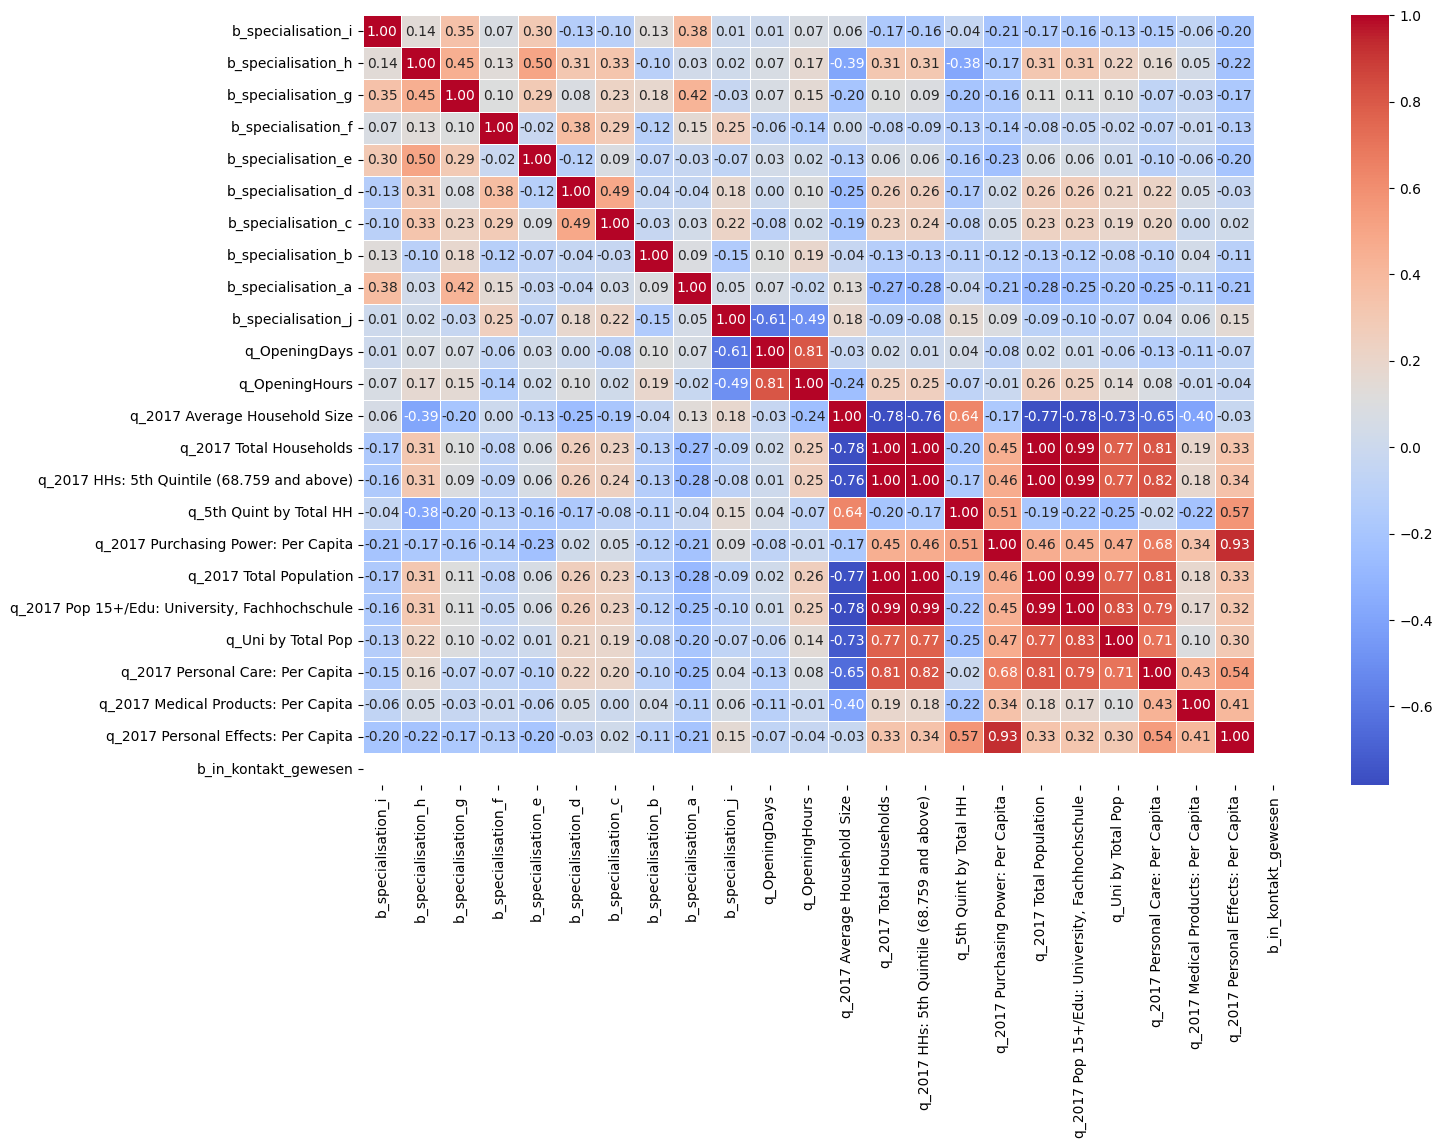

In [32]:
spearman_correlation(X_train_cv_)

### Conclusion:
There are several variables highly correlated. One could perhaps remove some of them either with a threshold or with an expert basis knowledge. However, we might lose the interactions between such correlated variables. 

## 2.7 Use UMAP https://umap-learn.readthedocs.io/en/latest/clustering.html

UMAP (Uniform Manifold Approximation and Projection) is used for dimensionality reduction and visualization in machine learning and data analysis tasks. The method presents several advantages:

* Dimensionality Reduction: UMAP reduces high-dimensional data to a lower-dimensional space while preserving the inherent structure and relationships, making it suitable for visualizing clusters and patterns.

* Non-linear Embedding: Unlike traditional methods like PCA, UMAP captures complex non-linear relationships in the data, allowing it to potentially reveal clusters that align with target variables more accurately.


* Preserves Global Structure: UMAP optimizes a low-dimensional embedding that preserves both local and global structures of the data, maintaining meaningful distances between data points.


In [35]:
X_temp = df_training.copy()

In [36]:
reducer = umap.UMAP()

In [37]:
X_scaled = StandardScaler().fit_transform(X_temp)

In [38]:
embedding = reducer.fit_transform(X_scaled)
embedding.shape

(95, 2)

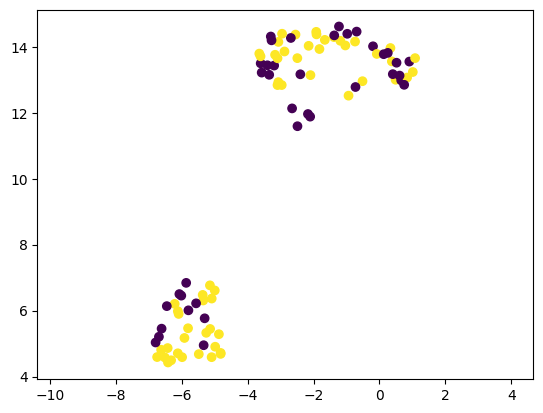

In [39]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=X_temp['b_gekauft_gesamt'], cmap='viridis')
plt.gca().set_aspect('equal', 'datalim')


### Conclusion: 
It is not so simple to interpret such results and transfer learning is difficult in this case

# 3. Reweighting dataset based on unlabeled data distribution 

In [40]:
!pwd

/home/lisbeth/Documents/Adelchi/customer_generator_temperature_readings2/notebooks


In [101]:
# Function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [116]:
df_unlabeld = df1[lambda x: x["b_in_kontakt_gewesen"]==0].copy()
# Apply the function to the column to create a boolean mask
non_numeric_mask = ~df_unlabeld['q_OpeningHours'].apply(is_numeric)

# Get rows with non-numeric strings in the column
non_numeric_rows = df_unlabeld[non_numeric_mask]
non_numeric_rows
# Drop rows with non-numeric strings
df_unlabeld = df_unlabeld[~non_numeric_mask]
X_unlabeld = df_unlabeld.drop(columns=['b_gekauft_gesamt'])  # Features
y_unlabeled = df_unlabeld['b_gekauft_gesamt']  # Target variable
seed=2014

In [117]:
# changing object type to float
X = X.assign(
        q_OpeningHours=lambda x: x.q_OpeningHours.astype('float'))
# changing object type to float
# Convert the column to numeric, setting errors='coerce' to replace non-numeric values with NaN
# X_unlabeld['q_OpeningHours_numeric'] = pd.to_numeric(X_unlabeld['q_OpeningHours'], errors='coerce')
X_unlabeld = X_unlabeld.assign(
        q_OpeningHours=lambda x: x.q_OpeningHours.astype('float'))

### We need to retrain a classifier, given that Cinnamon does not accept a scikit learn pipeline yet and only support XGBoost and Catboost

In [119]:
# we do a time split (shuffle=False) to seperate between training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=1/5,
                                                      shuffle=True,
                                                      random_state=seed)
# Get the best parameters of XGBoost model from the pipeline
best_xgb_params = best_pipelines["XGBoost"].named_steps['model'].get_params()

# Create a new XGBClassifier using the best parameters
clf = XGBClassifier(**best_xgb_params)
# fitting clf
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20,
        verbose=10, eval_metric=['auc', 'logloss'])

[0]	validation_0-auc:0.58333	validation_0-logloss:0.69147
[10]	validation_0-auc:0.59615	validation_0-logloss:0.68097
[20]	validation_0-auc:0.59615	validation_0-logloss:0.67274
[30]	validation_0-auc:0.64103	validation_0-logloss:0.66274
[40]	validation_0-auc:0.69231	validation_0-logloss:0.65326
[50]	validation_0-auc:0.70513	validation_0-logloss:0.64586
[60]	validation_0-auc:0.69231	validation_0-logloss:0.63782
[70]	validation_0-auc:0.67949	validation_0-logloss:0.63284
[80]	validation_0-auc:0.70513	validation_0-logloss:0.63073
[90]	validation_0-auc:0.69231	validation_0-logloss:0.63079
[99]	validation_0-auc:0.67949	validation_0-logloss:0.63146


/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [122]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for both train and test sets
y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate AUC scores
auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f"AUC on X_train: {auc_train:.2f}")
print(f"AUC on X_test: {auc_test:.2f}")

AUC on X_train: 0.98
AUC on X_test: 0.69


/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## 3.1 Detection of data drift
We do detect a data drift in this case. Our three indicators:

* distribution of predictions
* distribution of target labels
* performance metrics

In [133]:
# initialize and fit a model drift explainer on test and unlabeled data
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_train, X2=X_unlabeld[X_test.columns.tolist()])#, y1=y_test, y2=y_unlabeled)

/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


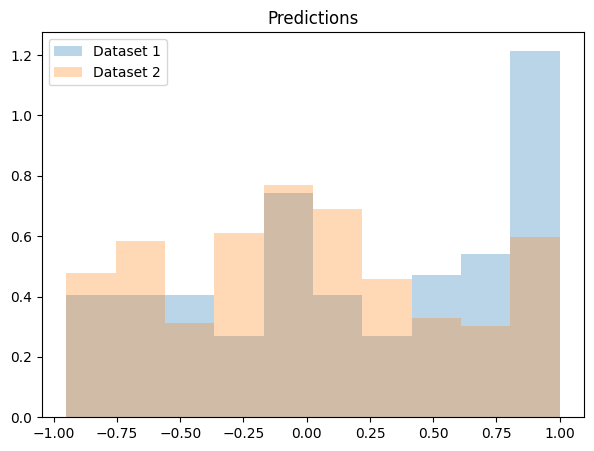

[DriftMetricsNum(mean_difference=-0.18993215447743989, wasserstein=0.19190301552829533, ks_test=BaseStatisticalTestResult(statistic=0.22078568054621187, pvalue=0.0011420608723442956))]

In [134]:
cinnamon.plot_prediction_drift(drift_explainer, bins=10)
drift_explainer.get_prediction_drift()

## 3.2. Explaination of data drift

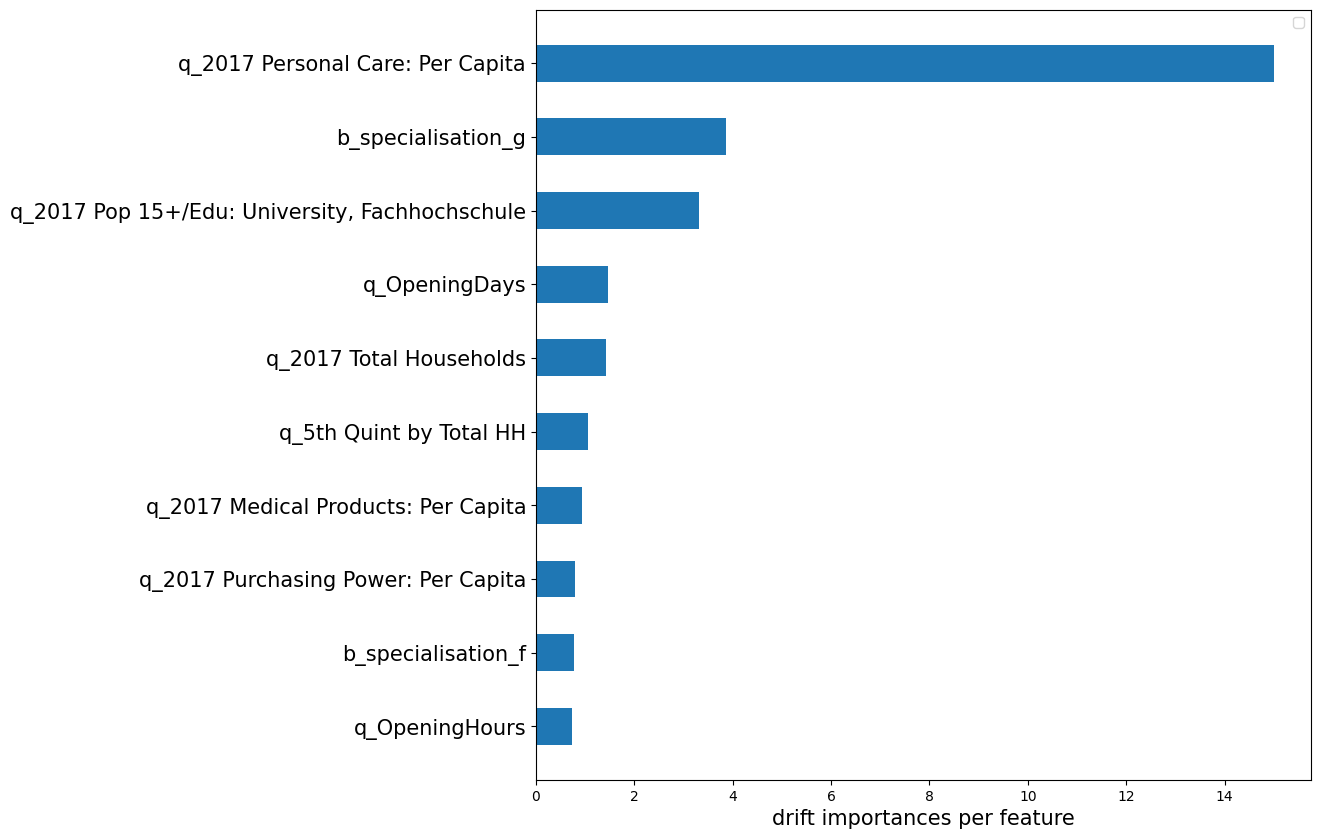

In [135]:
# plot drift importances in order to identify features that have the higher impacts on data drift
cinnamon.plot_tree_based_drift_importances(drift_explainer, type='node_size')

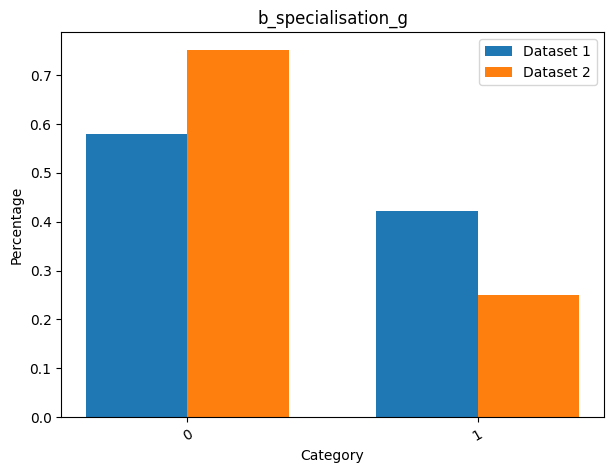

DriftMetricsNum(mean_difference=-0.17139258262599658, wasserstein=0.17139258262599655, ks_test=BaseStatisticalTestResult(statistic=0.1713925826259966, pvalue=0.02206342361699958))

In [136]:
first_drift_feature = 'b_specialisation_g'
# first drift value feature is 'card6' : the one we voluntarily add drift to.
cinnamon.plot_feature_drift(drift_explainer, first_drift_feature, as_discrete=True)
drift_explainer.get_feature_drift(first_drift_feature)

In [137]:
# feature importance of the model
feature_importance = pd.DataFrame(clf.feature_importances_, X_train.columns).sort_values(0, ascending=False)
feature_importance.head(10)

,0
"q_2017 Pop 15+/Edu: University, Fachhochschule",0.115200
q_2017 HHs: 5th Quintile (68.759 and above),0.091604
q_2017 Personal Care: Per Capita,0.083585
q_2017 Medical Products: Per Capita,0.081967
q_2017 Purchasing Power: Per Capita,0.081450
q_2017 Personal Effects: Per Capita,0.072098
q_Uni by Total Pop,0.067391
q_OpeningHours,0.063135
q_OpeningDays,0.058198
b_specialisation_g,0.058173


In [138]:
drifting_features_chosen = ["q_2017 Purchasing Power: Per Capita", "q_2017 Pop 15+/Edu: University, Fachhochschule", "q_2017 Personal Care: Per Capita",  "q_2017 Medical Products: Per Capita", 
                           "b_specialisation_g", "q_OpeningDays",]

## 3.3. Correction of data drift
Correction on test dataset

We apply our methodology which uses adversarial learning to correct data drift between test and prod data.

We then check our three indicators of data drift in order to see if we get improvement.

In [139]:
# weights computed with the adversarial method
# feature_subset=['card6']: only the first feature in terms of drift value is selected here
sample_weights_test_adversarial = (AdversarialDriftExplainer(feature_subset=drifting_features_chosen, seed=2021)
                                    .fit(X_train, X_unlabeld[X_test.columns.tolist()])
                                    .get_adversarial_correction_weights(max_ratio=10))

[16:30:15] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.44317	validation_0-auc:0.59375	validation_0-logloss:0.68704
[10]	validation_0-error:0.46294	validation_0-auc:0.58451	validation_0-logloss:0.76531
[20]	validation_0-error:0.47793	validation_0-auc:0.58919	validation_0-logloss:0.86754
[30]	validation_0-error:0.51914	validation_0-auc:0.56016	validation_0-logloss:1.00878
[40]	validation_0-error:0.50163	validation_0-auc:0.54832	validation_0-logloss:1.13043


/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[50]	validation_0-error:0.50935	validation_0-auc:0.54034	validation_0-logloss:1.23890
[60]	validation_0-error:0.50418	validation_0-auc:0.53166	validation_0-logloss:1.35473
[70]	validation_0-error:0.50336	validation_0-auc:0.53036	validation_0-logloss:1.46932
[80]	validation_0-error:0.50064	validation_0-auc:0.51930	validation_0-logloss:1.60439
[90]	validation_0-error:0.49956	validation_0-auc:0.52093	validation_0-logloss:1.69289
[100]	validation_0-error:0.49928	validation_0-auc:0.51049	validation_0-logloss:1.79353
[110]	validation_0-error:0.49901	validation_0-auc:0.51088	validation_0-logloss:1.88477
[120]	validation_0-error:0.49847	validation_0-auc:0.51121	validation_0-logloss:1.97145
[130]	validation_0-error:0.49874	validation_0-auc:0.50756	validation_0-logloss:2.06605
[140]	validation_0-error:0.49793	validation_0-auc:0.50425	validation_0-logloss:2.16664
[150]	validation_0-error:0.49793	validation_0-auc:0.49886	validation_0-logloss:2.26435
[160]	validation_0-error:0.49765	validation_0-au

/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [140]:
sample_weights_test_adversarial.min()

0.010244030238425256

In [141]:
# study the drift with the new weights on test data
drift_explainer2 = ModelDriftExplainer(clf)
drift_explainer2.fit(X1=X_train, X2=X_unlabeld[X_test.columns.tolist()], y1=y_test, y2=y_unlabeled,
                     sample_weights1=sample_weights_test_adversarial)

/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


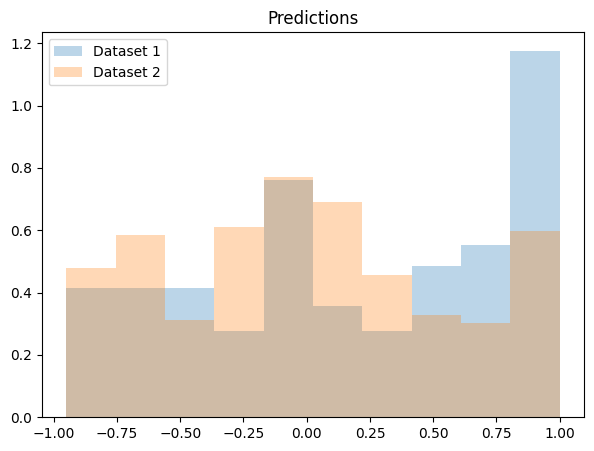

[DriftMetricsNum(mean_difference=-0.18135623389540798, wasserstein=0.18356116197229103, ks_test=BaseStatisticalTestResult(statistic=0.21739534222476942, pvalue=0.0015002881362771905))]

In [142]:
# with new weigts on test data, distributions of predictions are much closer
cinnamon.plot_prediction_drift(drift_explainer2, bins=10)
drift_explainer2.get_prediction_drift()

## 3.4. Correction on validation dataset and train dataset (in order to retrain the model)
We apply the same adversarial strategy on training data.

In [165]:
# weights computed with the adversarial method on training data
sample_weights_train_adversarial = (AdversarialDriftExplainer(feature_subset=drifting_features_chosen, seed=2021, verbosity=False)
                                    .fit(X_train_cv, X_unlabeld[X_test.columns.tolist()])
                                    .get_adversarial_correction_weights(max_ratio=10))

/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[17:01:24] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:01:26] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [166]:
# weights computed with the adversarial method on training data
sample_weights_train_adversarial = (AdversarialDriftExplainer(feature_subset=feature_importance, seed=2021, verbosity=False)
                                    .fit(X_train_cv, X_unlabeld[X_test.columns.tolist()])
                                    .get_adversarial_correction_weights(max_ratio=10))

/home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[17:01:46] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:01:48] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [167]:
sample_weights_train_adversarial.min()

0.9552372298581243

In [159]:
sample_weights_test_adversarial.min()

0.010244030238425256

## 3.5. Retrain cross-validation with weights computed - compute auc with weights

In [168]:
best_pipelines["Random Forest"]

Pipeline(steps=[('encoder',
                 BinningProcess(max_pvalue=0.05,
                                variable_names=['b_specialisation_i',
                                                'b_specialisation_h',
                                                'b_specialisation_g',
                                                'b_specialisation_f',
                                                'b_specialisation_e',
                                                'b_specialisation_d',
                                                'b_specialisation_c',
                                                'b_specialisation_b',
                                                'b_specialisation_a',
                                                'b_specialisation_j',
                                                'q_OpeningDays',
                                                'q_OpeningHours',
                                                'q_2017 Average Household Size',
                                                'q_2...
                                                'q_2017 Purchasing Power: Per '
                                                'Capita',
                                                'q_2017 Total Population',
                                                'q_2017 Pop 15+/Edu: '
                                                'University, Fachhochschule',
                                                'q_Uni by Total Pop',
                                                'q_2017 Personal Care: Per '
                                                'Capita',
                                                'q_2017 Medical Products: Per '
                                                'Capita',
                                                'q_2017 Personal Effects: Per '
                                                'Capita',
                                                'b_in_kontakt_gewesen'])),
                ('model',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=200, random_state=0))])

In [169]:
from sklearn.pipeline import clone
# cloning pipeline
pipeline_to_retrain = clone(best_pipelines["Random Forest"])
# Retrain the pipeline with sample weights
pipeline_to_retrain.fit(X_train_cv, y_train_cv, model__sample_weight=sample_weights_train_adversarial)

Pipeline(steps=[('encoder',
                 BinningProcess(max_pvalue=0.05,
                                variable_names=['b_specialisation_i',
                                                'b_specialisation_h',
                                                'b_specialisation_g',
                                                'b_specialisation_f',
                                                'b_specialisation_e',
                                                'b_specialisation_d',
                                                'b_specialisation_c',
                                                'b_specialisation_b',
                                                'b_specialisation_a',
                                                'b_specialisation_j',
                                                'q_OpeningDays',
                                                'q_OpeningHours',
                                                'q_2017 Average Household Size',
                                                'q_2...
                                                'q_2017 Purchasing Power: Per '
                                                'Capita',
                                                'q_2017 Total Population',
                                                'q_2017 Pop 15+/Edu: '
                                                'University, Fachhochschule',
                                                'q_Uni by Total Pop',
                                                'q_2017 Personal Care: Per '
                                                'Capita',
                                                'q_2017 Medical Products: Per '
                                                'Capita',
                                                'q_2017 Personal Effects: Per '
                                                'Capita',
                                                'b_in_kontakt_gewesen'])),
                ('model',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=200, random_state=0))])

In [175]:
# Predict probabilities on X_val
y_proba = pipeline_to_retrain.predict_proba(X_val)[:, 1]  # Use [:, 1] for positive class probability

# Compute AUC
auc_score = roc_auc_score(y_val, y_proba)

# Compute Brier Score
brier_score = brier_score_loss(y_val, y_proba)

print(f"AUC on X_val: {np.round(auc_score,2)}")
print(f"Brier Score on X_val: {np.round(brier_score,2)}")

AUC on X_val: 0.59
Brier Score on X_val: 0.28


# 4. Transfer learning using Partykit

In [259]:
# R functions
ctree_control = partykit.ctree_control
ctree = partykit.ctree
plot = ro.r['plot']
predict = ro.r['predict']

# Target
target = 'b_gekauft_gesamt'

# Filters
df_tmp = X_train_cv.copy()
df_tmp[target] = y_train_cv.copy()
# balancing same amount of 0 and 1
df_pk = pd.concat([df_tmp[lambda x: x[target]==1].sample(n=30, random_state=2), df_tmp[lambda x: x[target]==0]])
df_pk['q_OpeningHours'] = df_pk['q_OpeningHours'].astype('float')

add_filters = (df_pk[target].notna())
data = df_pk.loc[add_filters].copy()
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.replace(r'[\.\:\+/()\[\]\\,]', '', regex=True)

# Add base prediction to test corrector model
data['base_pred'] = 1

# Convert to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
    r_data = ro.conversion.py2rpy(data)
    r_base_pred = ro.conversion.py2rpy(data['base_pred'])

# Adjust mincriterion
p_value = 0.7
controls = ctree_control(mincriterion=1 - p_value, minsplit=3, minbucket=3)
# controls = ctree_control(mincriterion=0.35, minsplit=3, minbucket=3)


# Define the formula
formula_str = (
    'factor(' + target + ') ~ '
    # ' + b_specialisation_i'
    # ' + b_specialisation_h'
    # ' + b_specialisation_g'
    # ' + b_specialisation_f'
    # ' + b_specialisation_e'
    # ' + b_specialisation_d'
    # ' + b_specialisation_c'
    # ' + b_specialisation_b'
    # ' + b_specialisation_a'
    # ' + b_specialisation_j'
    # ' + q_OpeningDays'
    ' + q_2017_Average_Household_Size'
    # ' + q_2017_Total_Households'
    # ' + q_2017_HHs_5th_Quintile_68759_and_above'
    # ' + q_5th_Quint_by_Total_HH'
    ' + q_2017_Purchasing_Power_Per_Capita'
    # ' + q_2017_Total_Population'
    ' + q_2017_Pop_15Edu_University_Fachhochschule'
    ' + q_Uni_by_Total_Pop'
    ' + q_2017_Personal_Care_Per_Capita'
    ' + q_2017_Medical_Products_Per_Capita'
    # ' + q_2017_Personal_Effects_Per_Capita'
)
print(formula_str)

# Build the tree
ct = ctree(
    formula=Formula(formula_str),
    data=r_data,
    control=controls
)

# Plot tree
grdevices.png(file="./results/default_ctree_pt.png", width=2500, height=500)
plot(ct, type='simple')
grdevices.dev_off()

factor(b_gekauft_gesamt) ~  + q_2017_Average_Household_Size + q_2017_Purchasing_Power_Per_Capita + q_2017_Pop_15Edu_University_Fachhochschule + q_Uni_by_Total_Pop + q_2017_Personal_Care_Per_Capita + q_2017_Medical_Products_Per_Capita


1


#### We have a single split on q_Uni by Total Pop variable: values > 0.091 have a prediction of target=1 with an error of 40.9%. Furthermore, we identified a pocket of prediction = 0, with an error of 0% whenever 0.056 < q_Uni by Total Pop variable: values <= 0.091

In [266]:
df_unlabeld.filter(like='q_Uni')

,q_Uni by Total Pop
40,0.146405
47,0.148823
48,0.055140
54,0.146032
57,0.146399
...,...
3768,0.125418
3769,0.149148
3770,0.149137
3771,0.116490


In [279]:
df_unlabeld.shape

(3677, 26)

In [271]:
df_unlabeld_labeled = df_unlabeld.copy()
df_unlabeld_labeled['b_gekauft_gesamt'] = np.where(df_unlabeld_labeled['q_Uni by Total Pop'] > 0.091, 1, 0)
# removing zero observation for which we have a high error and removing target=1 since the error is also high (40%)
df_unlabeld_labeled = df_unlabeld_labeled[lambda x: (x['q_Uni by Total Pop']>0.056) & (x['q_Uni by Total Pop']<=0.091)]

In [272]:
print(df_unlabeld_labeled.shape)
print(df_unlabeld_labeled[target].value_counts())

(1004, 26)
0    1004
Name: b_gekauft_gesamt, dtype: int64


In [275]:
df_train_cv = X_train_cv.copy()
df_train_cv[target] = y_train_cv
df_train_cv_new = pd.concat([df_train_cv, df_unlabeld_labeled[df_train_cv.columns.tolist()]])
df_train_cv_new.shape

(1080, 25)

In [277]:
print(df_train_cv[target].value_counts())
print(df_train_cv_new[target].value_counts())

1    46
0    30
Name: b_gekauft_gesamt, dtype: int64
0    1034
1      46
Name: b_gekauft_gesamt, dtype: int64


## Retraining adding new observation for target=0 from unlabeled dataframe

In [278]:
# cloning pipeline
pipeline_to_retrain2 = clone(best_pipelines["Random Forest"])
# Retrain the pipeline with sample weights
pipeline_to_retrain2.fit(df_train_cv_new[X_train_cv.columns.tolist()], df_train_cv_new[target])
# Predict probabilities on X_val
y_proba = pipeline_to_retrain2.predict_proba(X_val)[:, 1]  # Use [:, 1] for positive class probability

# Compute AUC
auc_score = roc_auc_score(y_val, y_proba)

# Compute Brier Score
brier_score = brier_score_loss(y_val, y_proba)

print(f"AUC on X_val: {np.round(auc_score,2)}")
print(f"Brier Score on X_val: {np.round(brier_score,2)}")

AUC on X_val: 0.6
Brier Score on X_val: 0.32


# 5. Optimisation of F1 score via tuning of probability threshold

## 5.1 General performances metrics - TODO: apply it on X_validation only

Confusion Matrix:
[[3 5]
 [4 7]]


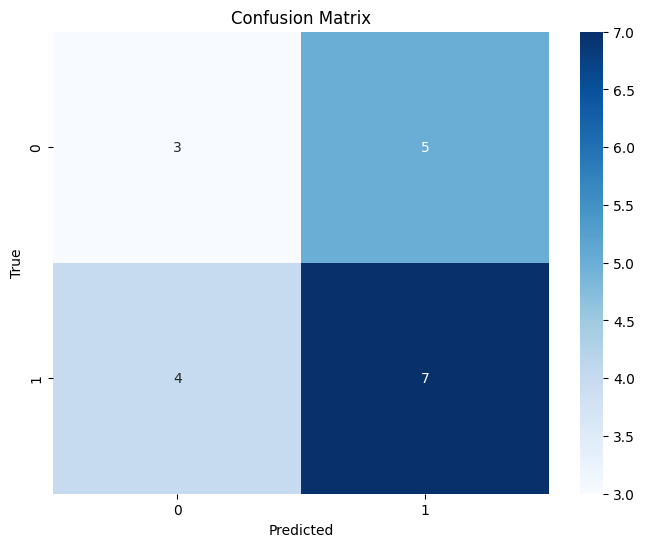

Accuracy: 0.53
Precision: 0.52
Recall: 0.53
F1 Score: 0.52


In [75]:
pipeline = best_pipelines["Random Forest"]
y_true = y_val.copy()
y_pred = pipeline.predict(X_val)
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Additional metrics
accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred, average='weighted')
recall = metrics.recall_score(y_true, y_pred, average='weighted')
f1_score = metrics.f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

##  5.2. Definition of optimal threshold probabilities for each class - we do not stick to the 0.5 default probability threshold

In [89]:
# Current performances metrics
classifier = pipeline
default_threshold=0.5
y_probabilities = classifier.predict_proba(X_val)[:, 1]  # Extract probabilities for the positive class
y_pred = (y_probabilities > default_threshold).astype(int)  # Extract probabilities for the positive class
# Extract true labels (assuming positive class is labeled as 1)
true_labels = y_val.astype(int)
# Print classification report
print("Classification Report:")
print(classification_report(true_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.58      0.64      0.61        11

    accuracy                           0.53        19
   macro avg       0.51      0.51      0.50        19
weighted avg       0.52      0.53      0.52        19



### New Performance - model improved ? 

In [176]:
# New performances with optimised threshold value
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, y_probabilities)

# Find the threshold that maximizes the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Use the optimal threshold to make final predictions
final_predictions = (y_probabilities > optimal_threshold).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, final_predictions))

# Optionally, print the optimal threshold
print(f"Optimal Threshold: {optimal_threshold}")


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.58      0.67        38
           1       0.76      0.89      0.82        57

    accuracy                           0.77        95
   macro avg       0.77      0.74      0.74        95
weighted avg       0.77      0.77      0.76        95

Optimal Threshold: 0.5339311703053329


## 5.3. Precision-recall curve

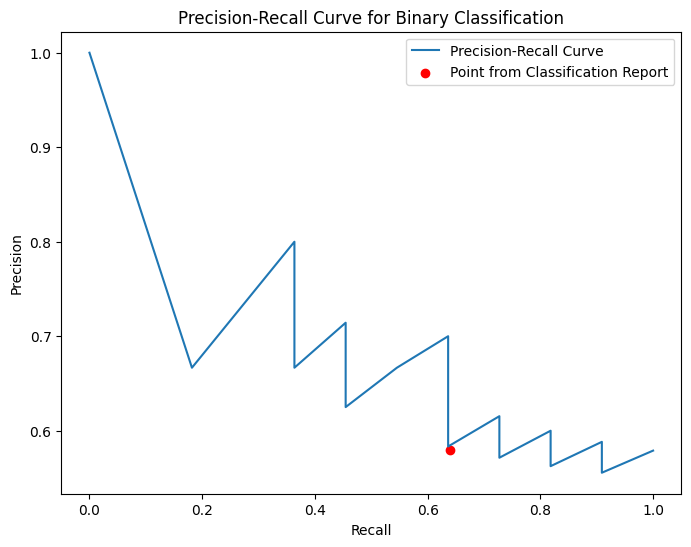

In [93]:
# Extract true labels (assuming positive class is labeled as 1)
true_labels = y_val.astype(int)

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, y_probabilities)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')

# Optional: Add a specific point from the classification report for illustration
plt.scatter([0.64], [0.58], c='red', marker='o', label='Point from Classification Report')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Binary Classification')
plt.legend()
plt.show()


# 6. Cost vs gain 


* Thresholds: The range of probability thresholds used to decide which predictions to consider as positive (contact the person).
  
* Contacts: The number of people you would contact at each threshold.
* Gains: The total gains from people who paid.
* Costs: The total costs of contacting people.
* Net Gains: The difference between gains and costs, showing the profit or loss.
* Predicted Probabilities: The predicted probabilities scaled and plotted as orange dots.
* Optimal Threshold: The vertical line and annotation indicate the point with the highest net gain, showing the optimal number of contacts.

* num_contacts: This should represent the total number of people the model decides to contact based on a probability threshold. It should count all instances where y_pred suggests contacting the person, regardless of whether they actually pay or not.

* num_payers: This should represent the number of people who actually pay for the product, based on both the true labels (y_true) and the predicted labels (y_pred).

This plot helps visualize the tradeoff and decide the optimal number of people to contact to maximize net gain. The orange dots show the distribution of predicted probabilities, allowing you to see how different thresholds affect the results.

In [115]:
def calculate_gains_and_costs(y_true, y_probs, cost_per_contact=5, gain_per_payment=10):
    thresholds = np.linspace(0, 1, 100)
    gains = []
    costs = []
    net_gains = []
    contacts = []

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        num_contacts = y_pred.sum()
        num_payers = (y_true & y_pred).sum()

        cost = num_contacts * cost_per_contact
        gain = num_payers * gain_per_payment
        net_gain = gain - cost

        contacts.append(num_contacts)
        gains.append(gain)
        costs.append(cost)
        net_gains.append(net_gain)

    return thresholds, contacts, gains, costs, net_gains

y_probs = classifier.predict_proba(X)[:, 1]
thresholds, contacts, gains, costs, net_gains = calculate_gains_and_costs(y, y_probs)


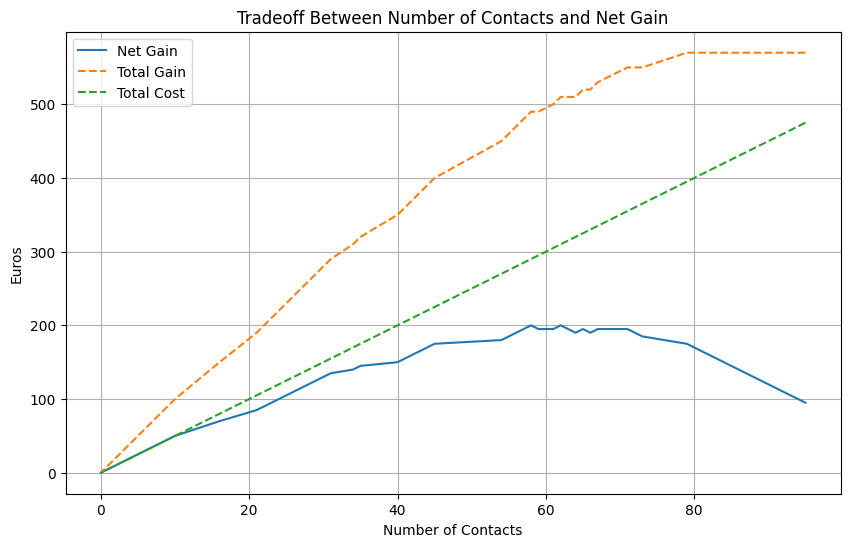

In [135]:
# Plot the tradeoff
plt.figure(figsize=(10, 6))
plt.plot(contacts, net_gains, label='Net Gain')
plt.plot(contacts, gains, label='Total Gain', linestyle='--')
plt.plot(contacts, costs, label='Total Cost', linestyle='--')
plt.xlabel('Number of Contacts')
plt.ylabel('Euros')
plt.title('Tradeoff Between Number of Contacts and Net Gain')
plt.legend()
plt.grid(True)
plt.show()


In [131]:
len(y)

95

In [132]:
62./95

0.6526315789473685

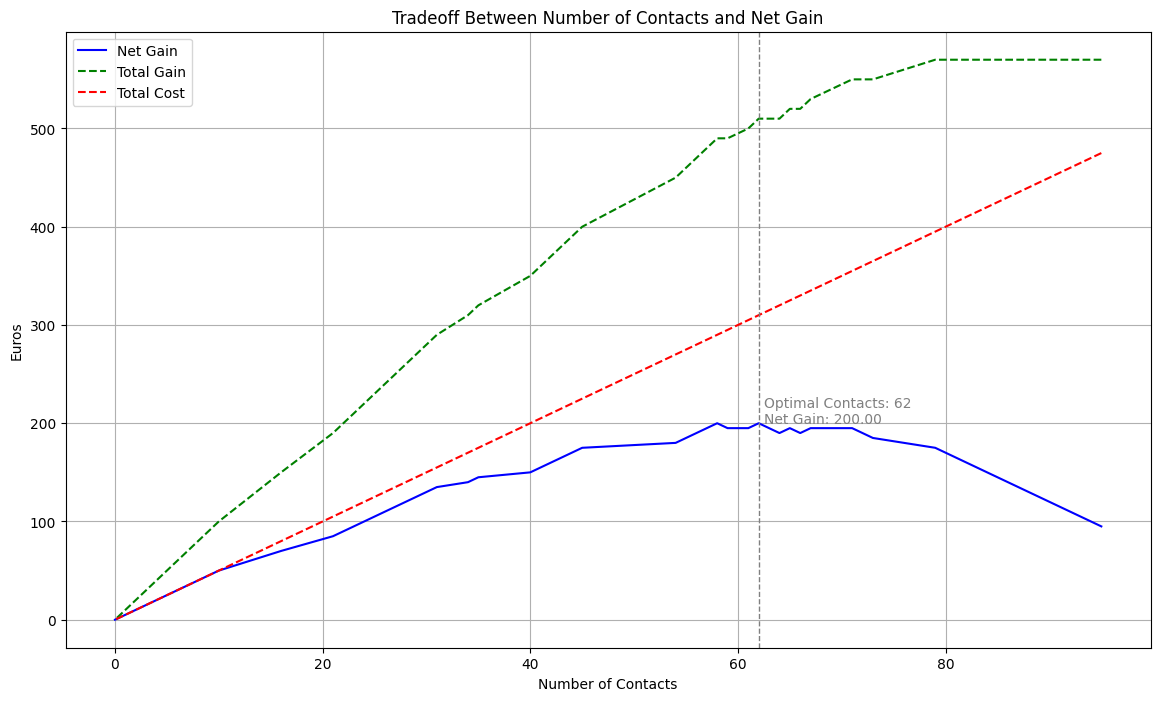

In [129]:
# Plot the tradeoff including y_probs and thresholds
plt.figure(figsize=(14, 8))

# Plot net gain, total gain, and total cost
plt.plot(contacts, net_gains, label='Net Gain', color='b')
plt.plot(contacts, gains, label='Total Gain', linestyle='--', color='g')
plt.plot(contacts, costs, label='Total Cost', linestyle='--', color='r')

# Add y_probs to the plot
sorted_probs = np.sort(y_probs)
sorted_contacts = np.argsort(y_probs) + 1  # Add 1 to avoid starting from zero

# plt.scatter(sorted_contacts, sorted_probs * 10, color='orange', label='Predicted Probabilities (scaled)')

plt.xlabel('Number of Contacts')
plt.ylabel('Euros')
plt.title('Tradeoff Between Number of Contacts and Net Gain')
plt.legend()
plt.grid(True)

# Highlight the optimal threshold
optimal_index = np.argmax(net_gains)
optimal_contacts = contacts[optimal_index]
optimal_net_gain = net_gains[optimal_index]
plt.axvline(x=optimal_contacts, color='grey', linestyle='--', linewidth=1)
plt.text(optimal_contacts + 0.5, optimal_net_gain, f'Optimal Contacts: {optimal_contacts}\nNet Gain: {optimal_net_gain:.2f}', color='grey')

# # Add vertical lines for thresholds
# for threshold in [0.25, 0.5, 0.75]:  # Example thresholds to show
#     scaled_threshold = threshold * len(y_probs)  # Scale to match the length of y_probs
#     plt.axvline(x=scaled_threshold, color='lightgrey', linestyle=':', linewidth=0.8)
#     plt.text(scaled_threshold + 2, 0.5, f'Threshold: {threshold:.2f}', color='grey')

plt.show()

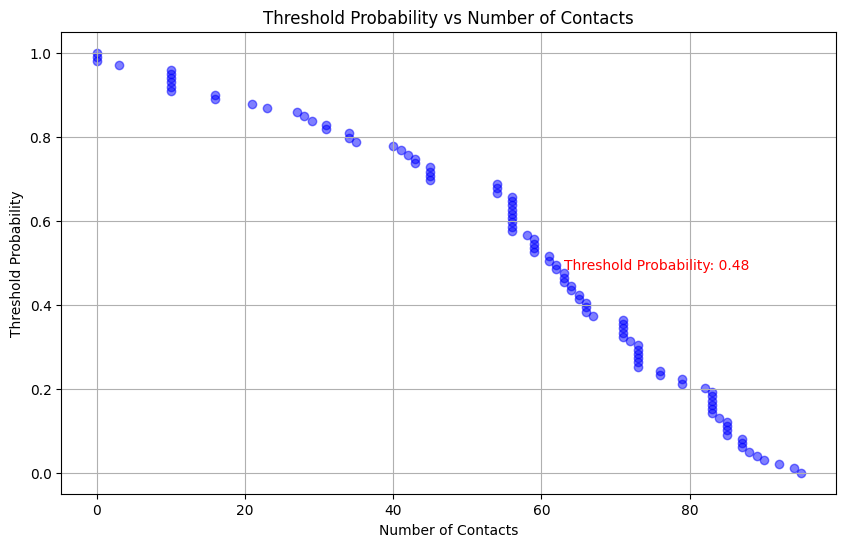

In [130]:
# Plotting y_probs vs Number of Contacts
plt.figure(figsize=(10, 6))
plt.scatter(contacts, thresholds, color='blue', alpha=0.5)
plt.xlabel('Number of Contacts')
plt.ylabel('Threshold Probability')
plt.title('Threshold Probability vs Number of Contacts')
plt.grid(True)

# Find the index closest to Number of Contacts = 62
target_contacts = 62
closest_index = np.argmin(np.abs(np.array(contacts) - target_contacts))

# Display the Threshold Probability for Number of Contacts = 62
plt.text(contacts[closest_index] + 1, thresholds[closest_index], f'Threshold Probability: {thresholds[closest_index]:.2f}', color='red')

plt.show()

# Stacked model

In [282]:
!ls ../

customer_analysis.zip  DataScienceCodingChallenge.pdf  README.md	 src
data		       notebooks		       requirements.txt


# Younited graph of Cost of risk 

In [213]:
!pip uninstall plotnine

Found existing installation: plotnine 0.13.6
Uninstalling plotnine-0.13.6:
  Would remove:
    /home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/plotnine-0.13.6.dist-info/*
    /home/lisbeth/Documents/Adelchi/zeiss_venv/lib/python3.9/site-packages/plotnine/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
